In [1]:
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
from PyEMD import EMD
from PyEMD import EEMD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
num_class = 12
close_num = 11 # 11か12か注意（close numを使ってるとこと整合性とれてるか）
batch_size = 64
learning_rate = 0.0001
num_epochs = 100
sequence_len = 250 * 5 # sampling_rate * second
overlap = int(sequence_len * 0.3)
alpha = 0.1

In [5]:
import pywt
def ecg_filter(data): # data: 1d array
    coeffs = pywt.wavedec(data,'db8',level=8)
    for i in np.arange(0,1,1):
        coeffs[i] = np.zeros_like(coeffs[i]) # 一番初めは最小の解像度の余りらしい
        # print("coeff length: {}".format(len(coeffs)))
        # print(f"1: {i}")
    for i in np.arange(-1,-2,-1):
        coeffs[i] = np.zeros_like(coeffs[i])
        # print(f"2: {i}")
    # print(coeffs)
    renc = pywt.waverec(coeffs, 'db8')    
    return renc

In [6]:
def segmentation(end_idx, sequence_len, overlap, data_list):
    """
    データのセグメンテーションを行う
    segmentation(len(data_np_unfil_norm), sequence_len, overlap, data_list)
    """
    seg_list = []

    for data in data_list:
        n = 0
        n_stop = sequence_len
        data_segs = []
        while n_stop < end_idx:
            n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
            n_stop = n_start + sequence_len
            seg = data[n_start:n_stop].copy()
            if len(seg) == sequence_len:
                data_segs.append([seg])
            n += 1
        seg_list.append(data_segs)
    return seg_list

#### sampling rate 250Hz 5sで1250 points

In [7]:
from scipy import signal
data_list = []
seg_list = []

for i in range(1, 12 + 1):
    scaler = StandardScaler()
    file_path = "./data/Keio Hospital/distance%02d.csv" % i
    csv = pd.read_csv(file_path)
    csv = csv.to_numpy()
    csv = scaler.fit_transform(csv)
    csv = ecg_filter(csv) # waveletを用いない場合はコメントアウト
    scaler = MinMaxScaler()
    csv = scaler.fit_transform(csv)

    data_list.append(csv[:, 1]) # waveletを用いない場合はコメントアウト
    # data_list.append(csv) # waveletを用いる場合はコメントアウト
seg_list = segmentation(len(csv), sequence_len, overlap, data_list)

/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: U

In [17]:
len(seg_list)

12

In [32]:
len(seg_list[0][0][0][0])

2

/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


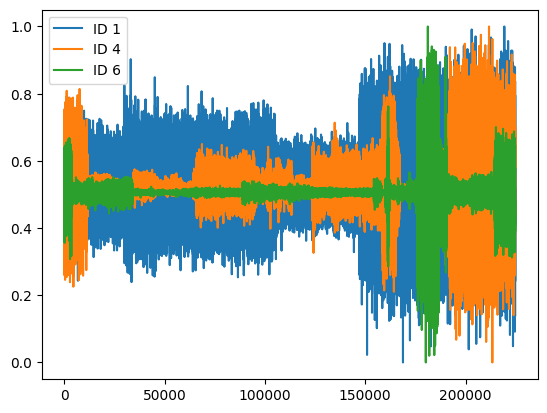

In [22]:
scaler = StandardScaler()
id_test = 0
id = ecg_filter(scaler.fit_transform(data_list[id_test]))
id4 = ecg_filter(scaler.fit_transform(data_list[3]))
id6 = ecg_filter(scaler.fit_transform(data_list[5]))
scaler = MinMaxScaler()
id = scaler.fit_transform(id)
id4 = scaler.fit_transform(id4)
id6 = scaler.fit_transform(id6)

# ids = [id4[:, 1], id6[:, 1]]
# print(len(ids))
# corr = np.correlate(id4[:, 1], id6[:, 1], "full")
# print(corr)

# plt.plot(corr, label="corr")
plt.plot(id[:, 1], label="ID 1")
plt.plot(id4[:, 1], label="ID 4")
plt.plot(id6[:, 1], label="ID 6")
plt.legend()


In [8]:
seg_re = np.reshape(seg_list, (3072, 1, 1250))
seg_re.shape

(3072, 1, 1250)

In [9]:
labels = []
for i in range(len(seg_list)):
    for j in range(len(seg_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1) # for open set

In [45]:
labels[-1], close_num

(11, 11)

In [46]:
len(labels)

3072

In [47]:
len(seg_list[0][0][0])

1250

In [48]:
seg_re.shape

(3072, 1, 1250)

In [10]:
data_set = []
# for i in range(len(seg_list)): # waveletありのとき
    # data_set.extend(seg_list[i])　
for i in range(len(seg_re)): # waveletなしのとき
    data_set.append(seg_re[i])

data_tensor_list = torch.tensor(data_set)
labels_tensor = torch.tensor(labels)
data_tensor_list.shape, labels_tensor.shape

/tmp/ipykernel_28570/2204223158.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data_tensor_list = torch.tensor(data_set)


(torch.Size([3072, 1, 1250]), torch.Size([3072]))

In [11]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 
        self.fc_tsne = nn.Linear(nf * 4, 2)
        self.two_vecs_train = [] # list is faster in appending
        self.two_vecs_test = []

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        # two_dimensional_vec = self.fc_tsne(x)
        # if self.training:
        #     self.two_vecs_train.append(two_dimensional_vec.tolist()) # あとでネストしたものをまとめてtensorかndarrayに変換するため
        # else:
        #     self.two_vecs_test.append(two_dimensional_vec.tolist())
        x = self.fc(x)
        return x

In [12]:
class HCU_Dataset(Dataset):
    def __init__(self, dataset, labels) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()        
        return self.radar_heartbeat[idx], self.labels[idx]

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = HCU_Dataset(data_tensor_list, labels_tensor)

### For Close Set

In [30]:
close_train_size = int(0.80 * len(dataset))
close_test_size = len(dataset) - close_train_size
close_train_set, close_test_set = torch.utils.data.random_split(dataset, [close_train_size, close_test_size])
print(f"Train Set: {len(close_train_set)}, Test Set: {len(close_test_set)}")
train_loader = DataLoader(dataset=close_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=close_test_set, batch_size=batch_size, shuffle=False)

Train Set: 2457, Test Set: 615


### For Open Set

In [121]:
dataset[1535][1], dataset[1536][1]

(tensor(5), tensor(6))

インデックスを2つに分ける．それぞれのサブセットで訓練とテストに分ける．
訓練は1つ目のサブセットのうちの8割のみを使用．
テストは両方のサブセットから2割ずつ取ってきて全て使用．

In [45]:
indices1 = np.arange(1535)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-5
indices2 = np.arange(1536, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 6-11
Unknown_label = close_num + 1

train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1
train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2
open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])
indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])

train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)
len(open_train_set), len(open_test_set)

(1228, 615)

In [13]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_only_truth = []
    for idx, x in enumerate(output):
        x = x[labels[idx]]
        x = torch.tensor(x).to(device)
        output_only_truth.append([x])
    output_only_truth = torch.tensor(output_only_truth)
    output_only_truth = output_only_truth.float()
    output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)

    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

In [14]:
from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

In [34]:
dataset[-1]

(tensor([[0.6354, 0.6358, 0.6358,  ..., 0.6331, 0.6326, 0.6323]],
        dtype=torch.float64),
 tensor(11))

In [117]:
model = InceptionTime(1, close_num + 1)
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
for epoch in mb:
    for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)
        outputs = model(signals)
        outputs = outputs.to(device)
        loss = triple_joint_loss(outputs, labels, alpha)
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer.step()
        optimizer_centloss.step()
        # if (i + 1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

/tmp/ipykernel_26714/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


TensorBase([0.2293, 0.3566, 0.2126, 0.4864, 0.5246, 0.7504, 0.1797, 0.3231,
            0.2252, 0.1939, 0.3188, 0.1708, 0.2554, 0.2883, 0.3500, 0.9205,
            0.4922, 0.3156, 0.2260, 0.9377, 0.8291, 0.1721, 0.1695, 0.4050,
            0.2257, 0.3591, 0.7032, 0.8652, 0.3359, 0.9215, 0.5401, 0.1603,
            0.2669, 0.1542, 0.3050, 0.3352, 0.1801, 0.2197, 0.2351, 0.4946,
            0.7056, 0.3395, 0.3336, 0.3237, 0.3417, 0.1849, 0.3468, 0.2988,
            0.1944, 0.7887, 0.4417, 0.3188, 0.1715, 0.2708, 0.2966, 0.3526,
            0.6328, 0.3284, 0.9516, 0.3938, 0.1674, 0.1826, 0.3006, 0.4285],
           device='cuda:0') TensorBase([2, 5, 4, 8, 8, 8, 3, 8, 4, 3, 0, 2, 9, 4, 8, 8, 7, 7, 4, 8, 8, 3, 7,
            4, 4, 4, 8, 8, 7, 8, 8, 4, 0, 7, 5, 8, 2, 2, 7, 7, 8, 0, 7, 8, 2, 7,
            7, 4, 3, 8, 8, 5, 7, 7, 4, 7, 8, 0, 8, 8, 7, 4, 0, 5],
           device='cuda:0') tensor([ 6,  6,  6,  5, 11,  9,  4,  9, 11,  2,  9,  2,  9,  9,  7,  5,  0, 10,
         1,  5,  8,  2,  3

Text(77.92222222222227, 0.5, 'Ground Truth')

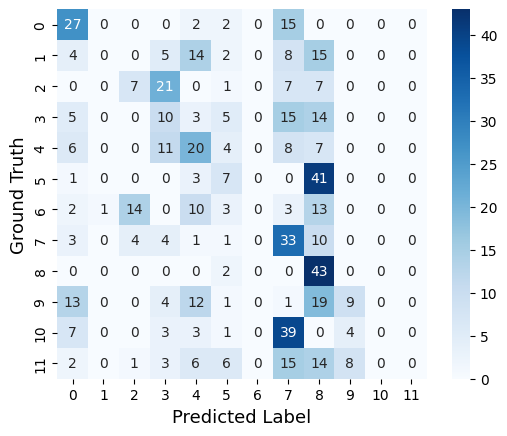

In [118]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
threshold = 0.65
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)
    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    """
    # Opensetのためのthreshold-softmax
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    """
    print(_, predicted, one_hot_labels)
    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)

### Cross Validation for Open set

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0

dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

for Fold, (train_index, test_index) in enumerate(skf.split(data_series, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    open_train_index = [i for i in train_index if i <= split_idx]
    open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    # train_set = torch.utils.data.Subset(dataset, train_index)
    # test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
    model.eval()
    for threshold in thresholds:
      predicted_lists = np.zeros(0, dtype=np.int64)
      one_hot_labels_list = np.zeros(0, dtype=np.int64)
      with torch.no_grad():
        n_correct = 0
        n_samples = 0
        softmax = nn.Softmax()
        for i, (signals, one_hot_labels) in enumerate(test_loader):
          signals = torch.tensor(signals)
          signals = signals.float()
          signals = signals.to(device)
          one_hot_labels = one_hot_labels.to(device)
          # print(len(one_hot_labels))
          outputs = model(signals)
          # if i == 1:
          
            # print(outputs)
          for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

          _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
          for idx in range(len(_)):
            if _[idx] < threshold:
              predicted[idx] = Unknown_label # 15, 20, 25
          # print(_, predicted, one_hot_labels)

          n_samples += one_hot_labels.size(0) # add batch_size
          n_correct += (predicted == one_hot_labels).sum().item()
          
          predicted_cp = predicted.to('cpu').detach().numpy().copy()
          one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
          predicted_lists = np.concatenate([predicted_lists, predicted_cp])
          one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
          
          acc = 100.0 * n_correct / n_samples
          # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
        with open("cross_val_result_close.txt", "a") as f:
          f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
          f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


        cm = confusion_matrix(one_hot_labels_list, predicted_lists)
        sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
        plt.xlabel("Predicted Label", fontsize=13)
        plt.ylabel("Ground Truth", fontsize=13)
        fig_name = "cross_val_Fold{}_threshold{}.png".format(Fold, threshold)
        plt.savefig("./figure/cross_val_open/" + fig_name)
        plt.close()
      
      if threshold == 0.7:
        mean_acc += acc
print(mean_acc / 10.0)

### Cross Validation for Close-set

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0

dataset = HCU_Dataset(data_tensor_list, labels_tensor)

for Fold, (train_index, test_index) in enumerate(skf.split(data_tensor_list, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    # open_train_index = [i for i in train_index if i <= split_idx]
    # open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    # open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    train_set = torch.utils.data.Subset(dataset, train_index)
    test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    # Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    # thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
    model.eval()
    # for threshold in thresholds:
    predicted_lists = np.zeros(0, dtype=np.int64)
    one_hot_labels_list = np.zeros(0, dtype=np.int64)
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      softmax = nn.Softmax()
      for i, (signals, one_hot_labels) in enumerate(test_loader):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        # print(len(one_hot_labels))
        outputs = model(signals)
        # if i == 1:
        
          # print(outputs)
        for j, out in enumerate(outputs):
          outputs[j] = softmax(out)

        _, predicted = torch.max(outputs.data, 1) # predicted per batch size
        """"""
        # for idx in range(len(_)):
          # if _[idx] < threshold:
            # predicted[idx] = Unknown_label # 15, 20, 25
        """"""
        # print(_, predicted, one_hot_labels)

        n_samples += one_hot_labels.size(0) # add batch_size
        n_correct += (predicted == one_hot_labels).sum().item()
        
        predicted_cp = predicted.to('cpu').detach().numpy().copy()
        one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
        predicted_lists = np.concatenate([predicted_lists, predicted_cp])
        one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
        
        acc = 100.0 * n_correct / n_samples
        # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
      with open("cross_val_result_HCU_close.txt", "a") as f:
        f.write(f"Fold{Fold+1}\n")
        f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


      cm = confusion_matrix(one_hot_labels_list, predicted_lists)
      sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
      plt.xlabel("Predicted Label", fontsize=13)
      plt.ylabel("Ground Truth", fontsize=13)
      fig_name = "cross_val_Fold{}_close.png".format(Fold)
      plt.savefig("./figure/HCU_cross_val_close/" + fig_name)
      plt.close()
    
    # if threshold == 0.7:
    mean_acc += acc
print(mean_acc / 10.0)

Fold1 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/center_loss.py:45: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor 

Fold2 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold3 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold4 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold5 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold6 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold7 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold8 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold9 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

Fold10 Start!


/tmp/ipykernel_28570/2790633555.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_28570/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_28570/2790633555.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

77.31079994923644
